In [12]:
import os
from pathlib import Path
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
from torchvision import transforms

from sklearn.model_selection import train_test_split

from torchsummary import summary

In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset_dir: Path, annotations_path: Path, transform=None) -> None:
        super().__init__()
        self.dataset_dir = dataset_dir
        self.df = pd.read_csv(annotations_path)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        observation = self.df.iloc[index, :]
        image1_path = self.dataset_dir / str(observation['label1']) / observation['image1']
        image2_path = self.dataset_dir / str(observation['label2']) / observation['image2']

        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        similarity = [float(observation['similarity'])]

        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return image1, image2, torch.FloatTensor(similarity)

In [3]:
annotations_path = Path("dataset.csv")
dataset_dir = Path("curated_dataset")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(dataset_dir=dataset_dir,
                        annotations_path=annotations_path,
                        transform=transform)

In [4]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 295
Test Dataset size: 33


In [3]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate Euclidean distance between output1 and output2
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        # Contrastive loss
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim: int = 256):
        super(SiameseNetwork, self).__init__()
        # Load a pre-trained ResNet-34 model
        self.backbone = models.resnet34(pretrained=True)

        # Replace the fully connected layer (fc) with an embedding layer
        # The output feature size can be a hyperparameter, for example 128
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_dim)

        # Optionally add a normalization layer
        self.norm = nn.BatchNorm1d(embedding_dim)

    def forward_once(self, x):
        # Forward pass through the backbone model
        output = self.backbone(x)

        # Normalize the output
        output = self.norm(output)

        return output

    def forward(self, input1, input2):
        # Get the output embeddings for both inputs
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [8]:
model = SiameseNetwork(embedding_dim=256)

In [ ]:
summary(model, input_size=[(3, 224, 224)*2], batch_size=-1)

In [8]:
# Initialize the Siamese Network
model = SiameseNetwork(embedding_dim=256).cuda()  # If you have a GPU

# Initialize the Contrastive Loss
criterion = ContrastiveLoss(margin=1.0)

# Optimizer (you can use Adam, SGD, etc.)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Number of epochs
num_epochs = 200

# Early stopping parameters
patience = 10  # How many epochs to wait after last time validation loss improved.
best_loss = float('inf')
early_stopping_counter = 0

# Initialize lists to keep track of loss
train_loss_list = []
val_loss_list = []

# Checkpoint directory
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        img0, img1, labels = data
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()  # If you have a GPU

        # set first step to zero grad
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs1, outputs2 = model(img0, img1)

        # Calculate Loss: contrastive loss
        loss = criterion(outputs1, outputs2, labels)

        # Calculate the backpropagation
        loss.backward()

        # update the weights
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation loss
    model.eval()  # Set model to evaluate mode
    with torch.no_grad():
        val_running_loss = 0.0
        for data in test_loader:
            img0, img1, labels = data
            img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()  # If you have a GPU
            outputs1, outputs2 = model(img0, img1)
            val_loss = criterion(outputs1, outputs2, labels)
            val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(test_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Train Loss: {avg_train_loss:.4f}, Avg. Validation Loss: {avg_val_loss:.4f}, Loss: {loss.item()}, Val. Loss: {val_loss.item()}')

    # save the loss
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss.item())

    # Early stopping
    if avg_val_loss < best_loss:
        early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth'))
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

/home/web-scientia/miniconda3/envs/experimental/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/web-scientia/miniconda3/envs/experimental/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/200], Avg. Train Loss: 69.7911, Avg. Validation Loss: 19816.3252, Loss: 1.6605280637741089, Val. Loss: 0.0
Epoch [2/200], Avg. Train Loss: 52.1557, Avg. Validation Loss: 0.6518, Loss: 0.23655548691749573, Val. Loss: 0.4810553193092346
Epoch [3/200], Avg. Train Loss: 42.2031, Avg. Validation Loss: 0.5641, Loss: 11.43220329284668, Val. Loss: 0.927367627620697
Epoch [4/200], Avg. Train Loss: 43.6944, Avg. Validation Loss: 0.8389, Loss: 110.10953521728516, Val. Loss: 0.9702374935150146
Epoch [5/200], Avg. Train Loss: 25.8498, Avg. Validation Loss: 189.5852, Loss: 0.9605120420455933, Val. Loss: 0.0
Epoch [6/200], Avg. Train Loss: 23.4995, Avg. Validation Loss: 3.0395, Loss: 4.166671276092529, Val. Loss: 0.0
Epoch [7/200], Avg. Train Loss: 12.8485, Avg. Validation Loss: 6.9852, Loss: 0.1692342460155487, Val. Loss: 0.30432790517807007
Epoch [8/200], Avg. Train Loss: 6.7516, Avg. Validation Loss: 0.5634, Loss: 2.7680649757385254, Val. Loss: 0.9661304354667664
Epoch [9/200], Avg. Train

In [9]:
# Load the best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

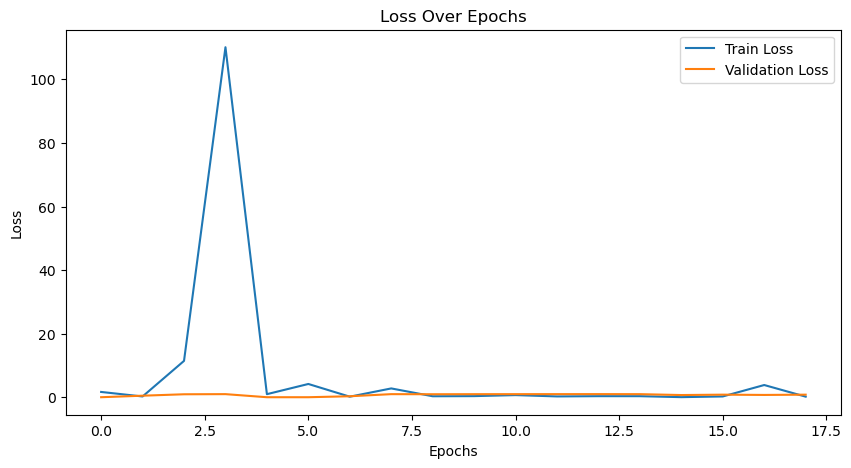

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Are the images similar? No
Pairwise distance: 0.10408858954906464


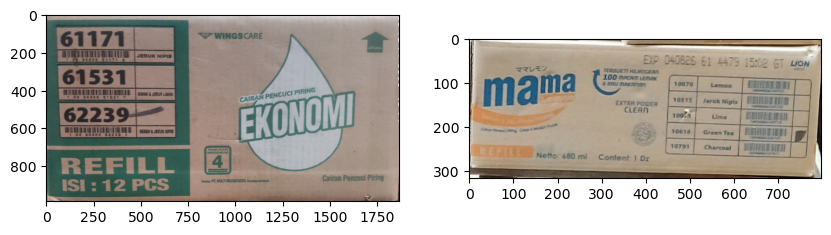

In [33]:
import torch
from torchvision import transforms
from PIL import Image

# Load the model
# model = SiameseNetwork().cuda()  # or .cpu() if you're not using a GPU
# model.backbone.fc.load_state_dict(torch.load('checkpoints/model_epoch_74.pth'), strict=False)
# model.eval()  # Set the model to evaluation mode

# Define the image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess the image
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function for inference
def infer(siamese_model, img1_path, img2_path, threshold):
    img1 = process_image(img1_path).cuda()  # or .cpu()
    img2 = process_image(img2_path).cuda()  # or .cpu()

    with torch.no_grad():  # No need to track gradients
        output1, output2 = siamese_model(img1, img2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        similarity = euclidean_distance < threshold
        return similarity.item(), euclidean_distance.item()

# Provide the paths to your images
image_path1 = 'curated_dataset/11/20231016_145128.jpg'
image_path2 = 'testing/25/1.jpg'

image1 = Image.open(image_path1)
image2 = Image.open(image_path2)

# Define a similarity threshold
similarity_threshold = 0.1  # This is a hyperparameter you can tune

# Run inference
is_similar, distance = infer(model, image_path1, image_path2, similarity_threshold)
print(f"Are the images similar? {'Yes' if is_similar else 'No'}")
print(f"Pairwise distance: {distance}")

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].imshow(image1)
axs[1].imshow(image2)

plt.show()

In [32]:
img11 = process_image(image_path1).to(device)# or .cpu()
img21 = process_image(image_path2).to(device) 
output1, output2 = model(img11, img21)
euclidean_distance = F.pairwise_distance(output1, output2)
similarity = euclidean_distance < 0.1
similarity.item(),euclidean_distance.item()

(False, 0.10408858954906464)

In [29]:
output1, output2

(tensor([[-0.1946, -0.1911,  0.1971, -0.1939, -0.1953,  0.1915, -0.1928,  0.1922,
          -0.1871, -0.1928,  0.1942,  0.1972,  0.1987,  0.1904,  0.1906,  0.1940,
           0.1990, -0.1909, -0.1930, -0.1965,  0.1907, -0.1937, -0.1933, -0.1982,
          -0.1943,  0.2058, -0.1929,  0.1912, -0.1942,  0.1927,  0.1943, -0.1947,
           0.1884, -0.1931,  0.1993,  0.1937,  0.1936, -0.1989, -0.1923, -0.1915,
          -0.1886,  0.1941, -0.1900, -0.1994, -0.1905, -0.1925, -0.1915,  0.1922,
           0.1915,  0.1973,  0.1938, -0.1939, -0.1914,  0.1925,  0.1912,  0.1942,
          -0.1937,  0.1925, -0.1886, -0.1928, -0.1920,  0.1958, -0.1946,  0.1927,
           0.1925, -0.1999,  0.1935, -0.1941,  0.1938, -0.1937,  0.1907, -0.1936,
           0.1997, -0.1900, -0.1932,  0.1927, -0.1926,  0.1935,  0.1921, -0.1955,
           0.1934,  0.1935, -0.1922,  0.1901, -0.1984, -0.1928, -0.1912, -0.1953,
           0.1942, -0.1935, -0.1926, -0.1931, -0.1927,  0.1894, -0.1961, -0.1912,
          -0.192

In [12]:
class EmbeddingDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        # dataset_path is the path to the directory where your dataset is located
        self.dataset_path = dataset_path
        self.transform = transform
        self.samples = []

        # Load the dataset - replace with your actual data loading logic
        for class_folder_name in os.listdir(self.dataset_path):
            class_folder_path = os.path.join(self.dataset_path, class_folder_name)
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                # The label is determined by the folder name, replace with your logic if needed
                label = int(class_folder_name)
                self.samples.append((image_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        # Load image
        image = Image.open(image_path).convert('RGB')
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming '/path/to/dataset' is the path to your dataset directory
dataset = EmbeddingDataset(dataset_path='curated_dataset', transform=transform)

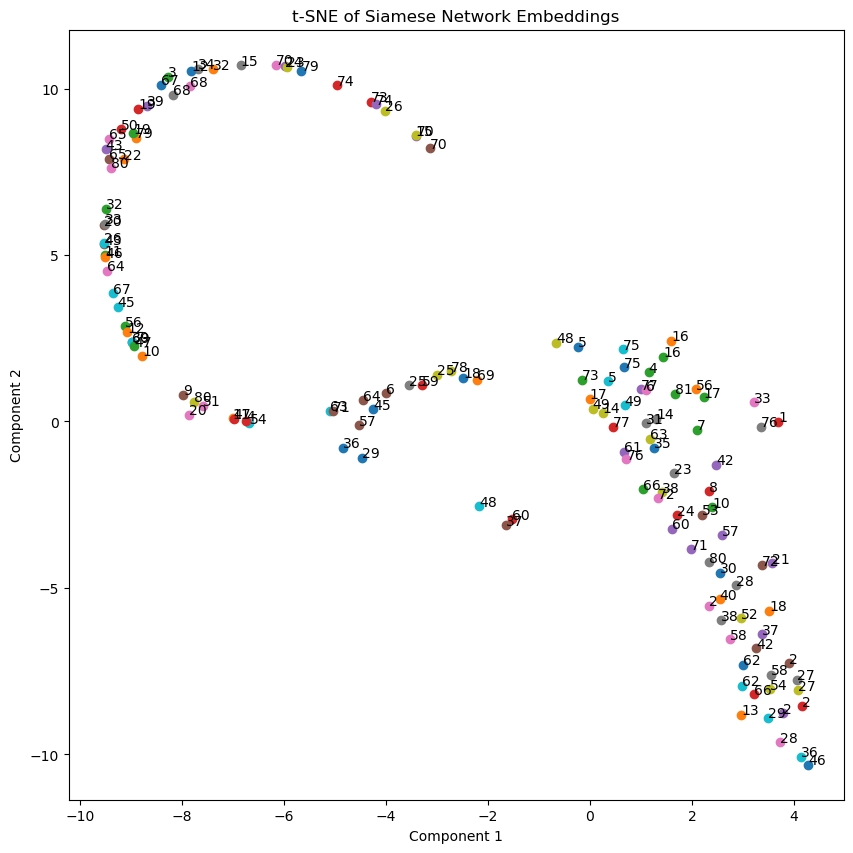

In [13]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define the device for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Function to get embeddings from the model
def get_embeddings(dataloader, model):
    with torch.no_grad():
        embeddings = np.array([])
        labels = np.array([])
        for i, data in enumerate(dataloader, 0):
            inputs, target_labels = data
            inputs = inputs.cuda()  # or .cpu()
            outputs = model.forward_once(inputs)
            if len(embeddings) == 0:
                embeddings = outputs.cpu().numpy()
                labels = target_labels.numpy()
            else:
                embeddings = np.vstack((embeddings, outputs.cpu().numpy()))
                labels = np.append(labels, target_labels.numpy())
        return embeddings, labels

# Extract embeddings and corresponding labels
embeddings, labels = get_embeddings(data_loader, model)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))
for i in range(len(embeddings)):

    x = transformed_embeddings[i, 0]
    y = transformed_embeddings[i, 1]
    plt.scatter(x, y, label=labels[i])
    plt.annotate(str(labels[i]), (x, y))

plt.title('t-SNE of Siamese Network Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
